# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Prepare Synthetic MNIST digit sequences

('Attempting to download:', 'train-images-idx3-ubyte.gz')
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
('Found and verified', './mnist_data/train-images-idx3-ubyte.gz')
('Attempting to download:', 'train-labels-idx1-ubyte.gz')
0%..85%.
Download Complete!
('Found and verified', './mnist_data/train-labels-idx1-ubyte.gz')
('Attempting to download:', 't10k-images-idx3-ubyte.gz')
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
('Found and verified', './mnist_data/t10k-images-idx3-ubyte.gz')
('Attempting to download:', 't10k-labels-idx1-ubyte.gz')
0%180%
Download Complete!
('Found and verified', './mnist_data/t10k-labels-idx1-ubyte.gz')
Skipping extraction of mnist_data/train-images-idx3-ubyte.gz.
Skipping extraction of mnist_data/train-labels-idx1-ubyte.gz.
Skippi

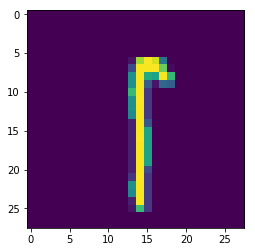

Display sample test image: index: 9596 label: 8


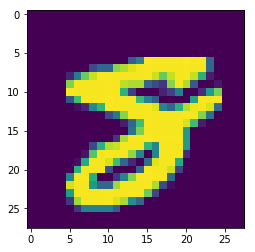

In [4]:
### Generating Synthetic MNIST Data

#!/usr/bin/env python2
# -*- coding: utf-8 -*-

"""
#%%
"""

# import modules

import numpy as np
import os
import random
import sys
import gzip
import idx2numpy 
import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy import ndimage
from scipy.misc import imsave
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from socket import socket

# global variables

idisplay = 1
num_merge = 5
img_height = 28
img_width = 28

np.random.seed(133)

# MNIST dataset
mnist_url = 'http://yann.lecun.com/exdb/mnist/'

#%%

# download, extract and display sample images

mnist_data = './mnist_data/'
if not os.path.isdir(mnist_data):    
    print ('Creating dir:', mnist_data)
    os.mkdir(mnist_data)

# reused/modified from tensorflow 1_notmnist.ipynb

last_percent_reported = None
def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(url, filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url+filename, mnist_data+filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return mnist_data+filename

mnist_train_images_gz = maybe_download(mnist_url, 'train-images-idx3-ubyte.gz', 9912422)
mnist_train_labels_gz = maybe_download(mnist_url, 'train-labels-idx1-ubyte.gz', 28881)
mnist_test_images_gz  = maybe_download(mnist_url, 't10k-images-idx3-ubyte.gz', 1648877)
mnist_test_labels_gz  = maybe_download(mnist_url, 't10k-labels-idx1-ubyte.gz', 4542)

def maybe_extract(filename):
    fname = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isfile(fname):
        print('Skipping extraction of %s.' % (filename))
    else:
        print('Extracting %s ...' % (filename))
        cmd = 'gunzip {}'.format(filename)
        os.system(cmd)
    return fname

maybe_extract('mnist_data/train-images-idx3-ubyte.gz')
maybe_extract('mnist_data/train-labels-idx1-ubyte.gz')
maybe_extract('mnist_data/t10k-images-idx3-ubyte.gz')
maybe_extract('mnist_data/t10k-labels-idx1-ubyte.gz')

train_samples = idx2numpy.convert_from_file('mnist_data/train-images-idx3-ubyte')
train_labels  = idx2numpy.convert_from_file('mnist_data/train-labels-idx1-ubyte')
test_samples  = idx2numpy.convert_from_file('mnist_data/t10k-images-idx3-ubyte')
test_labels   = idx2numpy.convert_from_file('mnist_data/t10k-labels-idx1-ubyte')

def display_samples(data, labels, text=None, num_samples=1, idx='rand', squeeze=0):
    for i in range(num_samples):
        if idx == 'rand':
            idx = random.choice(range(data.shape[0]))

        print 'Display sample {} image: index: {} label: {}'.format(text, idx, labels[idx])
        if squeeze == 0:
            plt.imshow(data[idx], interpolation='nearest')
        else:
            plt.imshow(np.squeeze(data[idx], axis=(2,)), interpolation='nearest')
        
        plt.show()
        
if idisplay:
    display_samples(train_samples, train_labels, text='train', num_samples=1)
    display_samples(test_samples, test_labels, text='test', num_samples=1)


Display sample train image: index: 69290 label: [0 1 2 7 0 1]


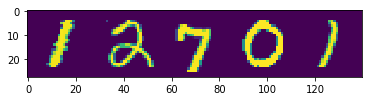

Display sample test image: index: 16043 label: [ 0  4  1  4 10 10]


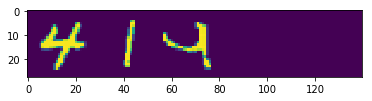

In [5]:
def createSequences(data, labels, img_height, img_width, merge=5):
    num_merged = int(data.shape[0]/merge)
    nlabels = np.ndarray(shape=(data.shape[0]*2, merge+1), dtype=np.int32)
    ndata = np.ndarray(shape=(data.shape[0]*2, img_height, img_width*merge), dtype=np.float32)
    
    for i in range(merge*2):
        rand_idx = random.sample(range(0, data.shape[0]), data.shape[0])
        w = 0; 
        for j in range(num_merged):
            a, b, c, d, e = rand_idx[w:w+merge]
            num_rand = random.choice(range(1,6))
            zeros = np.zeros([28,28])
            if num_rand == 5: 
                ndata[(i*num_merged)+j,:,:] = np.concatenate([data[a],data[b],data[c],data[d],data[e]], axis=1)
                nlabels[(i*num_merged)+j,:] = np.hstack([0,labels[a],labels[b],labels[c],labels[d],labels[e]])
            elif num_rand == 4:
                ndata[(i*num_merged)+j,:,:] = np.concatenate([data[a],data[b],data[c],data[d],zeros], axis=1)
                nlabels[(i*num_merged)+j,:] = np.hstack([0,labels[a],labels[b],labels[c],labels[d],10])
            elif num_rand == 3:
                ndata[(i*num_merged)+j,:,:] = np.concatenate([data[a],data[b],data[c],zeros,zeros], axis=1)
                nlabels[(i*num_merged)+j,:] = np.hstack([0,labels[a],labels[b],labels[c],10,10])
            elif num_rand == 2:
                ndata[(i*num_merged)+j,:,:] = np.concatenate([data[a],data[b],zeros,zeros,zeros], axis=1)
                nlabels[(i*num_merged)+j,:] = np.hstack([0,labels[a],labels[b],10,10,10])
            elif num_rand == 1:
                ndata[(i*num_merged)+j,:,:] = np.concatenate([data[a],zeros,zeros,zeros,zeros], axis=1)
                nlabels[(i*num_merged)+j,:] = np.hstack([0,labels[a],10,10,10,10])
            w += merge

    # add dim for grey scale
    ndata = np.expand_dims(ndata, axis=3)
    
    return ndata, nlabels
    
m_train_samples, m_train_labels = createSequences(train_samples, 
                                                  train_labels, 
                                                  img_height=img_height, 
                                                  img_width=img_width, 
                                                  merge=num_merge)

m_test_samples, m_test_labels = createSequences(test_samples, 
                                                test_labels, 
                                                img_height=img_height, 
                                                img_width=img_width, 
                                                merge=num_merge)

if idisplay:
    display_samples(m_train_samples, m_train_labels, text='train', num_samples=1, squeeze=1)
    display_samples(m_test_samples, m_test_labels, text='test', num_samples=1, squeeze=1)


In [7]:
mnist_merged = './mnist_merged/'
mnist_merged_train = './mnist_merged/merged_train'
mnist_merged_test  = './mnist_merged/merged_test'

if not os.path.isdir(mnist_merged):    
    print ('Creating dir:', mnist_merged)
    os.mkdir(mnist_merged)
    os.mkdir(mnist_merged_train)
    os.mkdir(mnist_merged_test)

print 'Saving merged train images to: {} ...'.format(mnist_merged_train)
for i in range(m_train_samples.shape[0]):
    save_file = '{}/{}.png'.format(mnist_merged_train, i)
    imsave(save_file, (np.squeeze(m_train_samples[i], axis=(2,))))

print 'Saving merged test images to: {} ...'.format(mnist_merged_test)
for i in range(m_test_samples.shape[0]):
    save_file = '{}/{}.png'.format(mnist_merged_test, i)
    imsave(save_file, (np.squeeze(m_test_samples[i], axis=(2,))))

if idisplay:
    Image(filename='mnist_merged/merged_train/1.png')
    Image(filename='mnist_merged/merged_test/1.png')

# Save
m_train_samples_save = m_train_samples
m_train_labels_save = m_train_labels

# Create validation set (6000 of 60000)
nval = 6000
m_val_samples = np.ndarray(shape=(nval, img_height, img_width*num_merge), dtype=np.float32)
m_val_labels = np.ndarray(shape=(nval, num_merge), dtype=np.int32)

m_val_samples = m_train_samples[:nval,]
m_val_labels = m_train_labels[:nval,]
m_train_samples = np.delete(m_train_samples, np.r_[:nval], 0)
m_train_labels = np.delete(m_train_labels, np.r_[:nval], 0)

# Create Pickling File
print('Pickling data...')
pickle_file = 'mnist_merged/MNIST.merged.pickle'

print 'Train samples: {}'.format(m_train_samples.shape)
print 'Train labels: {}'.format(m_train_labels.shape)
print 'Validation samples: {}'.format(m_val_samples.shape)
print 'Validation labels: {}'.format(m_val_labels.shape)
print 'Test samples: {}'.format(m_test_samples.shape)
print 'Test labels: {}'.format(m_test_labels.shape)

try:
    f = open(pickle_file, 'wb')
    save = {
        'm_train_samples': m_train_samples,
        'm_train_labels': m_train_labels,
        'm_val_samples': m_val_samples,
        'm_val_labels': m_val_labels,
        'm_test_samples': m_test_samples,
        'm_test_labels': m_test_labels,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to {}: {}'.format(pickle_file, e))
    raise
    
statinfo = os.stat(pickle_file)
print('Success!')
print('Compressed pickle size: {}'.format(statinfo.st_size))


('Creating dir:', './mnist_merged/')
Saving merged train images to: ./mnist_merged/merged_train ...
Saving merged test images to: ./mnist_merged/merged_test ...
Pickling data...
Train samples: (114000, 28, 140, 1)
Train labels: (114000, 6)
Validation samples: (6000, 28, 140, 1)
Validation labels: (6000, 6)
Test samples: (20000, 28, 140, 1)
Test labels: (20000, 6)
Success!
Compressed pickle size: 2198560464


### MNIST : CNN Model to detect sequences up to 5 digits

In [9]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 20 22:19:29 2017

@author: harik
"""

""""
    -------------------------------------------------------------------------------
    CNN Model Architecture for multi digit recognition implemented with TensorFlow
    -------------------------------------------------------------------------------
      inputs    [batch_size, 28, 140, 1]
      conv1     [patch=3x15, stride=1x1, padding=valid, 16 features]
      relu1     [relu]
      maxpool1  [patch=2x2, stride=2x2, padding=valid]
      conv2     [patch=4x20, stride=1x1, padding=valid, 32 features]
      relu2     [relu]
      maxpool2  [patch=2x2, stride=2x2, padding=valid]
      conv3     [patch=5x22, stride=1x1, padding=valid, 96 features]
      relu2     [relu]
      drop_out  10 %
      fc        [nodes=64]
      outputs   [y1,y2,y3,y4,y5]

"""

#%%

# program mode control

debug     = 1
idisplay  = 1
svhn_en   = 0
mnist_en  = 1
restore_session = 0

if mnist_en:
    num_steps  = 7125
    num_val    = 6000
    num_tests  = 10000
    img_width  = 140
    img_height = 28
    session_name = 'session/digit_recognizer.ckpt'
    #session_name = 'save/session.mymodel.run2/digit_recognizer.mnist.ckpt'
elif svhn_en:
    num_steps  = 60000
    num_val    = 5684
    num_tests  = 13068
    img_width  = 32
    img_height = 32
    session_name = 'save/session.mymodel.run2/digit_recognizer.svhn.ckpt'


import pickle
import random
import numpy as np
import tensorflow as tf

if idisplay:
    import matplotlib.pyplot as plt
    from PIL import Image
    from IPython.display import display

if mnist_en:
    print 'Loading MNIST pickled data...'
    pickle_file = 'mnist_merged/MNIST.merged.pickle'
    
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        X_train_samples = save['m_train_samples']
        y_train_samples = save['m_train_labels']
        X_val_samples   = save['m_val_samples']
        y_val_samples   = save['m_val_labels']
        X_test_samples  = save['m_test_samples'][:4000,]
        y_test_samples  = save['m_test_labels'][:4000,]
        del save  
        print 'Training data shape: ', X_train_samples.shape
        print 'Training label shape:', y_train_samples.shape
        print 'Validation data shape:', X_val_samples.shape
        print 'Validation label shape:', y_val_samples.shape
        print 'Test data shape:     ', X_test_samples.shape
        print 'Test label shape:    ', y_test_samples.shape
        print 'Data successfully loaded !!'
elif svhn_en:
    print 'Loading SVHN pickled data...'
    pickle_file = 'svhn_data/SVHN.pickle'

    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        X_train_samples = save['train_dataset']
        y_train_samples = save['train_labels']
        X_val_samples   = save['valid_dataset']
        y_val_samples   = save['valid_labels']
        X_test_samples  = save['test_dataset']
        y_test_samples  = save['test_labels']
        del save  
        print 'Training data shape: ', X_train_samples.shape
        print 'Training label shape:', y_train_samples.shape
        print 'Validation data shape:', X_val_samples.shape
        print 'Validation label shape:', y_val_samples.shape
        print 'Test data shape:     ', X_test_samples.shape
        print 'Test label shape:    ', y_test_samples.shape
        print 'Data successfully loaded !!'


Loading MNIST pickled data...
Training data shape:  (114000, 28, 140, 1)
Training label shape: (114000, 6)
Validation data shape: (6000, 28, 140, 1)
Validation label shape: (6000, 6)
Test data shape:      (4000, 28, 140, 1)
Test label shape:     (4000, 6)
Data successfully loaded !!


Display sample train image: 27069


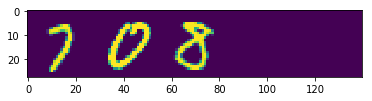

Display sample test image: 2877


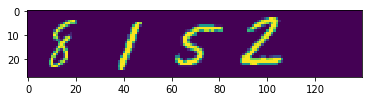

In [10]:
if idisplay:
    def display_samples(num_samples=1):
        for i in range(num_samples):        
            # train samples
            idx = random.choice(range(X_train_samples.shape[0]))
            print 'Display sample train image:', idx
            plt.imshow(X_train_samples[idx].reshape(img_height,img_width), interpolation='nearest')
            plt.show()

            # test samples
            idx = random.choice(range(X_test_samples.shape[0]))
            print 'Display sample test image:', idx
            plt.imshow(X_test_samples[idx].reshape(img_height,img_width), interpolation='nearest')
            plt.show()

    display_samples()


In [11]:
if mnist_en:

    # params
    in_chan    = 1         # grey scale
    batch_size = 16        # batch size

    # conv1
    c1_patch_h = 3         # patch size 3x15
    c1_patch_w = 15        # patch size 3x15
    c1_depth   = 16        # 16 features (out channels)
    c1_padding = 'VALID' # padding valid
    c1_stride  = [1,1,1,1] # stride 1x1

    # maxpool1
    p1_padding = 'VALID'   # padding valid
    p1_patch   = [1,2,2,1] # patch size 2x2
    p1_stride  = [1,2,2,1] # stride 2x2
    
    # conv2
    c2_patch_h = 4         # patch size 4x20
    c2_patch_w = 20        # patch size 4x20
    c2_depth   = 32        # 32 features (out channels)
    c2_padding = 'VALID'   # padding valid
    c2_stride  = [1,1,1,1] # stride 1x1

    # maxpool2
    p2_padding = 'VALID'   # padding valid
    p2_patch   = [1,2,2,1] # patch size 2x2
    p2_stride  = [1,2,2,1] # stride 2x2

    # conv3
    c3_patch_h = 5         # patch size 5x22
    c3_patch_w = 22        # patch size 5x22
    c3_depth   = 96        # 96 features (out channels)
    c3_padding = 'VALID'   # padding valid
    c3_stride  = [1,1,1,1] # stride 1x1

    # fc
    keep_prob  = 0.9       # dropout rate
    fc_nodes   = 64        # hidden layer

    # output
    out_digits = 6         # up to 5 digits [1-5]
    out_labels = 11        # detect 0-9 & none

elif svhn_en:
    
    # params
    in_chan    = 1         # grey scale
    batch_size = 16        # batch size

    # conv1
    c1_patch_h = 5         # patch size 5x5
    c1_patch_w = 5         # patch size 5x5
    c1_depth   = 16        # 16 features (out channels)
    c1_padding = 'VALID'   # padding valid
    c1_stride  = [1,1,1,1] # stride 1x1

    # maxpool1
    p1_padding = 'VALID'   # padding valid
    p1_patch   = [1,2,2,1] # patch size 2x2
    p1_stride  = [1,2,2,1] # stride 2x2
    
    # conv2
    c2_patch_h = 5         # patch size 5x5
    c2_patch_w = 5         # patch size 5x5
    c2_depth   = 32        # 32 features (out channels)
    c2_padding = 'VALID'   # padding valid
    c2_stride  = [1,1,1,1] # stride 1x1

    # maxpool2
    p2_padding = 'VALID'   # padding valid
    p2_patch   = [1,2,2,1] # patch size 2x2
    p2_stride  = [1,2,2,1] # stride 2x2

    # conv3
    c3_patch_h = 5         # patch size 5x5
    c3_patch_w = 5         # patch size 5x5
    c3_depth   = 96        # 96 features (out channels)
    c3_padding = 'VALID'   # padding valid
    c3_stride  = [1,1,1,1] # stride 1x1

    # fc
    keep_prob  = 0.8       # dropout rate
    fc_nodes   = 64        # hidden layer

    # output
    out_digits = 6         # up to 5 digits [1-5]
    out_labels = 11        # detect 0-9 & none


graph = tf.Graph()
with graph.as_default():    

    # in, out place holders

    X_val  = tf.constant(X_val_samples)
    X_test = tf.constant(X_test_samples)

    Y = tf.placeholder(tf.int32, shape=(batch_size, out_digits))
    X = tf.placeholder(tf.float32, shape=(batch_size, img_height, img_width, in_chan))

    # weights & biases

    def init_bias(name, shape):
        initializer = tf.contrib.layers.xavier_initializer()
        return tf.get_variable(shape=shape, name=name, initializer=initializer)

    def init_weight(name, shape):
        initializer = tf.contrib.layers.xavier_initializer_conv2d()
        return tf.get_variable(shape=shape, name=name, initializer=initializer)

    # pool_out = [(width or height) - patch]/(stride) + 1 
    # conv_out = [(width or height) - patch + 2 * pad]/(stride) + 1 
    def calc_out(w, h, p_w, p_h, stride, padding, type='conv'):
        pad = 1 if padding == 'SAME' else 0
        if type == 'pool':
            w_out = (w - p_w)/(stride) + 1
            h_out = (h - p_h)/(stride) + 1
        else:
            w_out = (w - p_w + 2 * pad)/(stride) + 1
            h_out = (h - p_h + 2 * pad)/(stride) + 1

        return w_out, h_out

    def calc_fc_size(im_w, im_h):
        (c1_w, c1_h) = calc_out(im_w, im_h, c1_patch_w,  c1_patch_h,  c1_stride[1], c1_padding, type='conv')
        (p1_w, p1_h) = calc_out(c1_w, c1_h, p1_patch[1], p1_patch[1], p1_stride[1], p1_padding, type='pool')
        (c2_w, c2_h) = calc_out(p1_w, p1_h, c2_patch_w,  c2_patch_h,  c2_stride[1], c2_padding, type='conv')
        (p2_w, p2_h) = calc_out(c2_w, c2_h, p2_patch[1], p2_patch[1], p2_stride[1], p2_padding, type='pool')
        (c3_w, c3_h) = calc_out(p2_w, p2_h, c3_patch_w,  c3_patch_h,  c3_stride[1], c3_padding, type='conv')

        print('Final image size after convolutions: {} x {}'.format(c3_w, c3_h))
        return c3_w, c3_h

    fc_w, fc_h = calc_fc_size(img_width, img_height)

    b_C1 = init_bias(name='b_C1', shape=[c1_depth])
    b_C2 = init_bias(name='b_C2', shape=[c2_depth])
    b_C3 = init_bias(name='b_C3', shape=[c3_depth])
    b_FC = init_bias(name='b_FC', shape=[fc_nodes])
        
    W_C1 = init_weight(name='W_C1', shape=[c1_patch_h, c1_patch_w, in_chan,  c1_depth])
    W_C2 = init_weight(name='W_C2', shape=[c2_patch_h, c2_patch_w, c1_depth, c2_depth])
    W_C3 = init_weight(name='W_C3', shape=[c3_patch_h, c3_patch_w, c2_depth, c3_depth])
    W_FC = init_weight(name='W_FC', shape=[fc_w * fc_h * c3_depth, fc_nodes])
        
    b_Y1 = init_bias(name='b_Y1', shape=[out_labels])
    b_Y2 = init_bias(name='b_Y2', shape=[out_labels])
    b_Y3 = init_bias(name='b_Y3', shape=[out_labels])
    b_Y4 = init_bias(name='b_Y4', shape=[out_labels])
    b_Y5 = init_bias(name='b_Y5', shape=[out_labels])
        
    W_Y1 = init_weight(name='W_Y1', shape=[fc_nodes, out_labels])
    W_Y2 = init_weight(name='W_Y2', shape=[fc_nodes, out_labels])
    W_Y3 = init_weight(name='W_Y3', shape=[fc_nodes, out_labels])
    W_Y4 = init_weight(name='W_Y4', shape=[fc_nodes, out_labels])
    W_Y5 = init_weight(name='W_Y5', shape=[fc_nodes, out_labels])
        
    # CNN Model
    def model(data, keep_prob):
        with tf.name_scope('layer_1'):
            c1_out = tf.nn.conv2d(data, W_C1, c1_stride, padding=c1_padding)
            r1_out = tf.nn.relu(c1_out + b_C1)
            p1_out = tf.nn.max_pool(r1_out, p1_patch, p1_stride, padding=p1_padding)
        
        with tf.name_scope('layer_2'):
            c2_out = tf.nn.conv2d(p1_out, W_C2, c2_stride, padding=c2_padding)
            r2_out = tf.nn.relu(c2_out + b_C2)
            p2_out = tf.nn.max_pool(r2_out, p2_patch, p2_stride, padding=p2_padding)
        
        with tf.name_scope('layer_3'):
            c3_out = tf.nn.conv2d(p2_out, W_C3, c3_stride, padding=c3_padding)
            r3_out = tf.nn.relu(c3_out + b_C3)
            d1_out = tf.nn.dropout(r3_out, keep_prob)
        
        with tf.name_scope('fc_layer'):
            shape   = d1_out.get_shape().as_list()
            reshape = tf.reshape(d1_out, [shape[0], shape[1] * shape[2] * shape[3]])
            fc_out  = tf.nn.relu(tf.matmul(reshape, W_FC) + b_FC)
        
        with tf.name_scope('softmax'):                
            y1 = tf.matmul(fc_out, W_Y1) + b_Y1
            y2 = tf.matmul(fc_out, W_Y2) + b_Y2
            y3 = tf.matmul(fc_out, W_Y3) + b_Y3
            y4 = tf.matmul(fc_out, W_Y4) + b_Y4
            y5 = tf.matmul(fc_out, W_Y5) + b_Y5

        return [y1, y2, y3, y4, y5]

    # Loss function: cross_entropy 
    [y1, y2, y3, y4, y5] = model(X, keep_prob)

    with tf.name_scope("cross_entropy"):        
        cross_entropy = \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(y1, Y[:, 1])) + \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(y2, Y[:, 2])) + \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(y3, Y[:, 3])) + \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(y4, Y[:, 4])) + \
            tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(y5, Y[:, 5]))
        tf.summary.scalar("cross_entropy", cross_entropy)

    # Optimizer
    alpha = 0.05; learn_step = tf.Variable(0)
    learn = tf.train.exponential_decay(alpha, learn_step, 10000, 0.96)
    optimizer = tf.train.AdagradOptimizer(learn).minimize(cross_entropy, global_step=learn_step)

    def softmax_combine(data):
        y = tf.pack([
            tf.nn.softmax(model(data, 1.0)[0]),
            tf.nn.softmax(model(data, 1.0)[1]),
            tf.nn.softmax(model(data, 1.0)[2]),
            tf.nn.softmax(model(data, 1.0)[3]),
            tf.nn.softmax(model(data, 1.0)[4])])
        return y

    y_pred      = softmax_combine(X)
    y_val_pred  = softmax_combine(X_val)
    y_test_pred = softmax_combine(X_test)

    # Save
    saver = tf.train.Saver()

    # weight histogram
    tf.summary.histogram("W_C1", W_C1)
    tf.summary.histogram("W_C2", W_C2)
    tf.summary.histogram("W_C3", W_C3)
    tf.summary.histogram("W_FC", W_FC)
    tf.summary.histogram("W_Y1", W_Y1)
    tf.summary.histogram("W_Y2", W_Y2)
    tf.summary.histogram("W_Y3", W_Y3)
    tf.summary.histogram("W_Y4", W_Y4)
    tf.summary.histogram("W_Y5", W_Y5)

    tf.summary.histogram("b_C1", b_C1)
    tf.summary.histogram("b_C2", b_C2)
    tf.summary.histogram("b_C3", b_C3)
    tf.summary.histogram("b_FC", b_FC)
    tf.summary.histogram("b_Y1", b_Y1)
    tf.summary.histogram("b_Y2", b_Y2)
    tf.summary.histogram("b_Y3", b_Y3)
    tf.summary.histogram("b_Y4", b_Y4)
    tf.summary.histogram("b_Y5", b_Y5)

    print('Graph done!')

#%%

def accuracy(predictions, labels, debug=0):
    if debug:
        for i in range(labels.shape[0]):
            print 'Test i:', np.argmax(predictions, 2).T[i], labels[i]

    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels)
             / predictions.shape[1] / predictions.shape[0])

def get_offset(step, batch_size, data):
    offset = (step * batch_size) % (data.shape[0] - batch_size)
    return offset

def model_loop(X_samples, y_samples, num_steps=1, debug=0):
    for step in range(num_steps):
        offset  = get_offset(step, batch_size, y_samples)
        batch_X = X_samples[offset:(offset + batch_size), :, :, :]
        batch_Y = y_samples[offset:(offset + batch_size), :]        
        feed_dict = {X: batch_X, Y: batch_Y}

        _, loss, pred, summary = sess.run([optimizer, cross_entropy, y_pred, merged], feed_dict=feed_dict)

        writer.add_summary(summary)

        if (step % 250 == 0):
            print (('step {}: loss -> {} accuracy -> {}%').format(step, round(loss,2), accuracy(pred, batch_Y[:,1:6], debug=debug)))
            print (('Validation accuracy: {}%'.format(round(accuracy(y_val_pred.eval(), y_val_samples[:,1:6], debug=debug), 2))))




Final image size after convolutions: 1 x 1
Graph done!


In [ ]:
#### Dont run this cell on normal machines. Logfile with the run on GoogleCloud is below

with tf.Session(graph=graph) as sess:
    writer = tf.summary.FileWriter("log", sess.graph)
    merged = tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())
    
    if restore_session:
        print('Restoring session: ', session_name)
        saver.restore(sess, session_name)
    else:
        # train loops
        print ('Start training: batch_size {} num_steps {}').format(batch_size, num_steps)
        model_loop(X_train_samples, y_train_samples, num_steps, debug=0)

    # test accuracy
    print ('Start Testing: num_tests {}').format(num_tests)
    print (('Test accuracy: {}%'.format(accuracy(y_test_pred.eval(), y_test_samples[:,1:6], debug=debug))))

    # save session
    save_path = saver.save(sess, "session/digit_recognizer.ckpt")
    print('Model saved to file: {}'.format(save_path))

print('Tensorboard: tensorboard --logdir=log')

#### Dont run this cell above on normal machines. Logfile with the run on GoogleCloud is below

Loading MNIST pickled data...

Training data shape:  (114000, 28, 140, 1)

Training label shape: (114000, 6)

Validation data shape: (6000, 28, 140, 1)

Validation label shape: (6000, 6)

Test data shape:      (4000, 28, 140, 1)

Test label shape:     (4000, 6)

Data successfully loaded !!

Final image size after convolutions: 1 x 1

Graph done!

Start training: batch_size 16 num_steps 7125

step 0: loss -> 77.57 accuracy -> 1.25%

Validation accuracy: 39.42%

...............

Validation accuracy: 89.86%

step 6750: loss -> 1.53 accuracy -> 96.25%

Validation accuracy: 89.74%

step 7000: loss -> 2.46 accuracy -> 87.5%

**Validation accuracy: 89.53%**

Start Testing: num_tests 10000

[ 8  4  2 10 10] [ 3  4  2 10 10]

[ 9  6  4 10 10] [ 9  6  4 10 10]

[ 0  3 10 10 10] [ 0  3 10 10 10]

[3 5 0 7 7] [3 5 0 9 2]

[ 4 10 10 10 10] [ 4 10 10 10 10]

[ 3 10 10 10 10] [ 3 10 10 10 10]

[1 9 3 7 7] [1 9 3 2 7]

..................

[ 3  4  6 10 10] [ 8  4  6 10 10]

[ 9 10 10 10 10] [ 9 10 10 10 10]


**Test accuracy: 90.695%**

Model saved to file: session/digit_recognizer.ckpt

Tensorboard: tensorboard --logdir=log


#### Full logfile: submission/mnist.run.log

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

- Step1: Create synthetic data by concatenating up to 5 digits from MNIST dataset
- Step2: Create pickle file with train, validation, and test samples
- Step3: Load pickle files and display sample data for sanity
- Step4: Use Tensor flow to create a CNN and train the model and compute validation accuracy
- Step5: Run the model on test set and compute accuracy

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

    -------------------------------------------------------------------------------------
    CNN Model Architecture for MNIST multi digit recognition implemented with TensorFlow
    -------------------------------------------------------------------------------------
      inputs    [batch_size, 28, 140, 1]
      conv1     [patch=3x15, stride=1x1, padding=valid, 16 features]
      relu1     [relu]
      maxpool1  [patch=2x2, stride=2x2, padding=valid]
      conv2     [patch=4x20, stride=1x1, padding=valid, 32 features]
      relu2     [relu]
      maxpool2  [patch=2x2, stride=2x2, padding=valid]
      conv3     [patch=5x22, stride=1x1, padding=valid, 96 features]
      relu2     [relu]
      drop_out  10 %
      fc        [nodes=64]
      outputs   [y1,y2,y3,y4,y5]


### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

- Synthetic data by concatenating up to 5 digits from MNIST dataset. The generated data was used to train the model. Example synthetic images below

Display sample train image: 16071


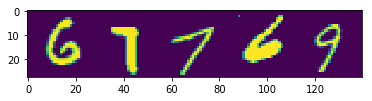

Display sample test image: 1357


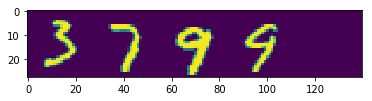

In [22]:
display_samples()

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Prepare SVHN data


In [ ]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 21 11:05:22 2017

@author: harik
"""

#%%

# import modules 

from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys
import tarfile
import h5py
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from PIL import Image

np.random.seed(133)

#%% 

# MNIST dataset

# SVHN dataset 
svhn_url = 'http://ufldl.stanford.edu/housenumbers/'

#%%

# download, extract and display sample images

svhn_data = './svhn_data/'
if not os.path.isdir(svhn_data):    
    print ('Creating dir:', svhn_data)
    os.mkdir(svhn_data)

# reused/modified from tensorflow 1_notmnist.ipynb

last_percent_reported = None
def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        

def maybe_download(url, filename, expected_bytes, force=False):
  """Create dir if not present"""
  """Download a file if not present, and make sure it's the right size."""
  
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url+filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

svhn_train_filename = maybe_download(svhn_url, 'train.tar.gz', 404141560)
svhn_test_filename = maybe_download(svhn_url, 'test.tar.gz', 276555967)
svhn_extra_filename = maybe_download(svhn_url, 'extra.tar.gz', 1955489752)


def maybe_extract(filename, force=False):
  global svhn_data
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(path=svhn_data)
    tar.close()
  return root
  
svhn_train_folder = 'svhn_data/' + maybe_extract(svhn_train_filename)
svhn_test_folder  = 'svhn_data/' + maybe_extract(svhn_test_filename)
svhn_extra_folder = 'svhn_data/' + maybe_extract(svhn_extra_filename)

def display_samples(data_folder, num_samples=1):
    for i in range(num_samples):
        im_name = random.choice(os.listdir(data_folder))
        im_file = data_folder + "/" + im_name
        #display(Image(filename=im_file))

#display_samples(svhn_train_folder)
#display_samples(svhn_test_folder)
#display_samples(svhn_extra_folder)
 
#%%

# resued/modified: from https://github.com/ritchieng/NumNum/NumNum/load_data.py

# Create dictionary for bounding boxes
print('Creating dictionary of bounding boxes...')
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox
    
    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result
    
print("Successfully created dictionary of bounding boxes!")
   
# Get Digit Structure
print('Getting digit structure for training data...')
digitFileTrain=DigitStructFile(os.path.join(svhn_train_folder,'digitStruct.mat'))
train_data=digitFileTrain.getAllDigitStructure_ByDigit()
print('Success!')

print('Getting digit structure for test data...')
digitFileTest=DigitStructFile(os.path.join(svhn_test_folder,'digitStruct.mat'))
test_data=digitFileTest.getAllDigitStructure_ByDigit()
print('Success!')

print('Getting digit structure for extra data...')
digitFileExtra=DigitStructFile(os.path.join(svhn_extra_folder,'digitStruct.mat'))
extra_data=digitFileExtra.getAllDigitStructure_ByDigit()
print('Success!')

# Crop Training Images
print('Cropping training images...')
train_imsize = np.ndarray([len(train_data),2])
for i in np.arange(len(train_data)):
    filename = train_data[i]['filename']
    fullname = os.path.join(svhn_train_folder, filename)
    im = Image.open(fullname)
    train_imsize[i, :] = im.size[:]

print('Success!')

# Crop Test Images
print('Cropping test images...')
test_imsize = np.ndarray([len(test_data),2])
for i in np.arange(len(test_data)):
    filename = test_data[i]['filename']
    fullname = os.path.join(svhn_test_folder, filename)
    im = Image.open(fullname)
    test_imsize[i, :] = im.size[:]

print('Success!')

# Crop Extra Images
print('Cropping extra images...')
extra_imsize = np.ndarray([len(extra_data),2])
for i in np.arange(len(extra_data)):
    filename = extra_data[i]['filename']
    fullname = os.path.join(svhn_extra_folder, filename)
    im = Image.open(fullname)
    extra_imsize[i, :] = im.size[:]

print('Success!')


def generate_dataset(data, folder):
    dataset = np.ndarray([len(data),32,32,1], dtype='float32')
    labels = np.ones([len(data),6], dtype=int) * 10
    for i in np.arange(len(data)):
        filename = data[i]['filename']
        fullname = os.path.join(folder, filename)
        im = Image.open(fullname)
        boxes = data[i]['boxes']
        num_digit = len(boxes)
        labels[i,0] = num_digit
        top = np.ndarray([num_digit], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        for j in np.arange(num_digit):
            if j < 5: 
                labels[i,j+1] = boxes[j]['label']
                if boxes[j]['label'] == 10: labels[i,j+1] = 0
            else: print('#',i,'image has more than 5 digits.')
            top[j] = boxes[j]['top']
            left[j] = boxes[j]['left']
            height[j] = boxes[j]['height']
            width[j] = boxes[j]['width']
        
        im_top = np.amin(top)
        im_left = np.amin(left)
        im_height = np.amax(top) + height[np.argmax(top)] - im_top
        im_width = np.amax(left) + width[np.argmax(left)] - im_left
        
        im_top = int(np.floor(im_top - 0.1 * im_height))
        im_left = int(np.floor(im_left - 0.1 * im_width))
        im_bottom = int(np.amin([np.ceil(im_top + 1.2 * im_height), im.size[1]]))
        im_right = int(np.amin([np.ceil(im_left + 1.2 * im_width), im.size[0]]))

        im = im.crop((im_left, im_top, im_right, im_bottom)).resize([32,32], Image.ANTIALIAS)
        im = np.dot(np.array(im, dtype='float32'), [[0.2989],[0.5870],[0.1140]])
        mean = np.mean(im, dtype='float32')
        std = np.std(im, dtype='float32', ddof=1)
        if std < 1e-4: std = 1.
        im = (im - mean) / std
        dataset[i,:,:,:] = im[:,:,:]

    return dataset, labels

print('Generating training dataset and labels...')
train_dataset, train_labels = generate_dataset(train_data, svhn_train_folder)
print('Success! \n Training set: {} \n Training labels: {}'.format(train_dataset.shape, train_labels.shape))

print('Generating testing dataset and labels...')
test_dataset, test_labels = generate_dataset(test_data, svhn_test_folder)
print('Success! \n Testing set: {} \n Testing labels: {}'.format(test_dataset.shape, test_labels.shape))

print('Generating extra dataset and labels...')
extra_dataset, extra_labels = generate_dataset(extra_data, svhn_extra_folder)
print('Success! \n Testing set: {} \n Testing labels: {}'.format(extra_dataset.shape, extra_labels.shape))

# Clean up data by deleting digits more than 5 (very few)
print('Cleaning up training data...')
train_dataset = np.delete(train_dataset, 29929, axis=0)
train_labels = np.delete(train_labels, 29929, axis=0)
print('Success!')

#%%
# Expand Training Data
print('Expanding training data randomly...')

random.seed(8)

n_labels = 10
valid_index = []
valid_index2 = []
train_index = []
train_index2 = []
for i in np.arange(n_labels):
    valid_index.extend(np.where(train_labels[:,1] == (i))[0][:400].tolist())
    train_index.extend(np.where(train_labels[:,1] == (i))[0][400:].tolist())
    valid_index2.extend(np.where(extra_labels[:,1] == (i))[0][:200].tolist())
    train_index2.extend(np.where(extra_labels[:,1] == (i))[0][200:].tolist())

random.shuffle(valid_index)
random.shuffle(train_index)
random.shuffle(valid_index2)
random.shuffle(train_index2)

valid_dataset = np.concatenate((extra_dataset[valid_index2,:,:,:], train_dataset[valid_index,:,:,:]), axis=0)
valid_labels = np.concatenate((extra_labels[valid_index2,:], train_labels[valid_index,:]), axis=0)
train_dataset_new = np.concatenate((extra_dataset[train_index2,:,:,:], train_dataset[train_index,:,:,:]), axis=0)
train_labels_new = np.concatenate((extra_labels[train_index2,:], train_labels[train_index,:]), axis=0)

print('Success! \n Training set: {} \n Training labels: {}'.format(train_dataset_new.shape, train_labels_new.shape))
print('Success! \n Validation set: {} \n Validation labels: {}'.format(valid_dataset.shape, valid_labels.shape))
print('Success! \n Testing set: {} \n Testing labels: {}'.format(test_dataset.shape, test_labels.shape))

#%%

# Create Pickling File
print('Pickling data...')
pickle_file = 'svhn_data/SVHN.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
        }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to {}: {}'.format(pickle_file, e))
    raise
    
statinfo = os.stat(pickle_file)
print('Success!')
print('Compressed pickle size: {}'.format(statinfo.st_size))



Found and verified train.tar.gz
Found and verified test.tar.gz
Found and verified extra.tar.gz
Extracting data for train. This may take a while. Please wait.
Extracting data for test. This may take a while. Please wait.
Extracting data for extra. This may take a while. Please wait.
Creating dictionary of bounding boxes...
Successfully created dictionary of bounding boxes!
Getting digit structure for training data...
Success!
Getting digit structure for test data...
Success!
Getting digit structure for extra data...

### SVHN: CNN Model to detect sequences up to 5 digits

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.